In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD

In [3]:
all_amplitude_envelope = []
FRAME_SIZE = 1024
HOP_LENGTH = 512

In [4]:
def amplitude_envelope(signal, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH):
    # make the amplitude envelope a list
    amplitude_envelope = []
    
    # calculate the amplitude envelope for each frame
    for i in range(0, len(signal), hop_length):
        current_frame_amplitude_envelope = max(signal[i : i + frame_size])
        amplitude_envelope.append(current_frame_amplitude_envelope)
        
    return np.array(amplitude_envelope)

In [6]:
frame_size = FRAME_SIZE
hop_length = HOP_LENGTH

In [7]:
mood = 'aggressive dramatic happy romantic sad'.split()
music_1d_sequence = []
emotion = []
i = 1
for m in mood:
    for filename in os.listdir(f'/kaggle/input/music-classification/dataset/{m}'):
        songname = f'/kaggle/input/music-classification/dataset/{m}/{filename}'
        sig, sr = librosa.load(songname, mono=True, duration=5)
        all_amplitude_envelope.append(amplitude_envelope(sig, frame_size, hop_length))
        emotion.append(m)
    print(f'Loading completed for {m}')

Loading completed for aggressive
Loading completed for dramatic
Loading completed for happy
Loading completed for romantic
Loading completed for sad


In [8]:
# Method 1
import csv
with open('amp_env.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(all_amplitude_envelope)

<a href="./amp_env.csv"> Download File </a>

In [11]:
data = pd.read_csv('amp_env.csv')

In [25]:
c = [str(i) for i in range(216)]

In [29]:
data.columns = c
data.columns
emotion = emotion[1:]

In [30]:
encoder = LabelEncoder()
y = encoder.fit_transform(emotion)#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data, dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [52]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [54]:
num_classes = 5

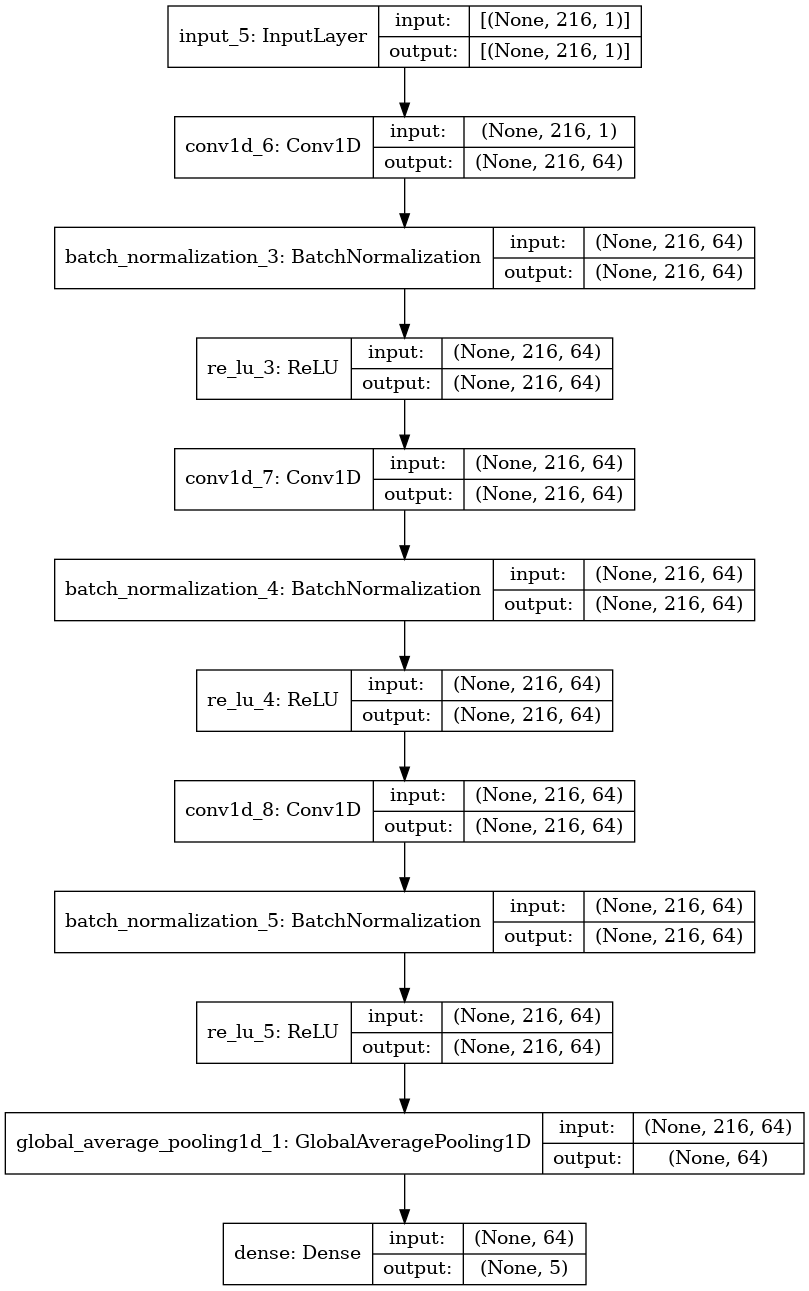

In [55]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [56]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
203/203 [==============================] - 9s 38ms/step - loss: 1.5645 - sparse_categorical_accuracy: 0.2755 - val_loss: 1.6702 - val_sparse_categorical_accuracy: 0.2141
Epoch 2/500
203/203 [==============================] - 8s 37ms/step - loss: 1.5131 - sparse_categorical_accuracy: 0.2900 - val_loss: 1.6379 - val_sparse_categorical_accuracy: 0.2572
Epoch 3/500
203/203 [==============================] - 7s 36ms/step - loss: 1.4956 - sparse_categorical_accuracy: 0.3137 - val_loss: 1.5139 - val_sparse_categorical_accuracy: 0.3226
Epoch 4/500
203/203 [==============================] - 7s 33ms/step - loss: 1.4936 - sparse_categorical_accuracy: 0.3337 - val_loss: 1.5503 - val_sparse_categorical_accuracy: 0.2832
Epoch 5/500
203/203 [==============================] - 7s 35ms/step - loss: 1.4681 - sparse_categorical_accuracy: 0.3442 - val_loss: 1.5903 - val_sparse_categorical_accuracy: 0.2869
Epoch 6/500
203/203 [==============================] - 7s 34ms/step - loss: 1.4665 - spars

In [57]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

64/64 [==============================] - 1s 8ms/step - loss: 1.0174 - sparse_categorical_accuracy: 0.5693
Test accuracy 0.5693142414093018
Test loss 1.0173779726028442


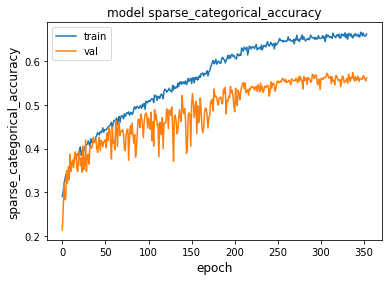

In [58]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

Resume training

In [59]:
history1 = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=1000,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/1000
203/203 [==============================] - 8s 36ms/step - loss: 0.8854 - sparse_categorical_accuracy: 0.6555 - val_loss: 1.0376 - val_sparse_categorical_accuracy: 0.5608
Epoch 2/1000
203/203 [==============================] - 7s 34ms/step - loss: 0.8748 - sparse_categorical_accuracy: 0.6552 - val_loss: 1.0545 - val_sparse_categorical_accuracy: 0.5651
Epoch 3/1000
203/203 [==============================] - 7s 34ms/step - loss: 0.8871 - sparse_categorical_accuracy: 0.6538 - val_loss: 1.0604 - val_sparse_categorical_accuracy: 0.5626
Epoch 4/1000
203/203 [==============================] - 7s 34ms/step - loss: 0.8804 - sparse_categorical_accuracy: 0.6590 - val_loss: 1.0520 - val_sparse_categorical_accuracy: 0.5614
Epoch 5/1000
203/203 [==============================] - 7s 35ms/step - loss: 0.8856 - sparse_categorical_accuracy: 0.6630 - val_loss: 1.0425 - val_sparse_categorical_accuracy: 0.5694
Epoch 6/1000
203/203 [==============================] - 7s 34ms/step - loss: 0.8877 -

In [60]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

64/64 [==============================] - 1s 8ms/step - loss: 0.9593 - sparse_categorical_accuracy: 0.5876
Test accuracy 0.5875678062438965
Test loss 0.9592625498771667


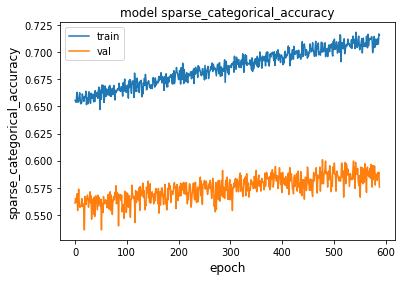

In [62]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history1.history[metric])
plt.plot(history1.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

OLD Code below, delete later

In [ ]:
# create a sequence classification instance
n_timesteps = 110250
# def get_sequence(n_timesteps):
    # create a sequence of random numbers in [0,1]
for k in range(len(music_1d_sequence)):
    encoder = LabelEncoder()
    y = encoder.fit_transform(emotion_list)#Scaling the Feature columns
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(music_1d_sequence, dtype = float))#Dividing data into training and Testing set

    # reshape input and output data to be suitable for LSTMs
    X = X.reshape(1, n_timesteps, 1)
    y = y.reshape(1, n_timesteps, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# define problem properties
n_timesteps = 110250
# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train LSTM
for epoch in range(1000):
    # generate new random sequence
    X,y = get_sequence(n_timesteps)
    # fit model for one epoch on this sequence
    model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

In [ ]:
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
    print('Expected:', y[0, i], 'Predicted', yhat[0, i])